# This notebook is to test several models for measuring the drop in $f_{features}$ in the FERENGI-fied galaxies. Refer to the link below for the final version, where zeta is calculated with the chosen model.¶

Link to Zeta.ipynb: https://github.com/willettk/gzhubble/blob/master/python/creating_debiased_catalog/STEP_2_zeta.ipynb


## We will use the AIC parameter to evaluate which model is the most appropriate.

The Akaike information criterion is a measure of relative quality of statistical models to a set of data. It is defined as:

## AIC = 2k - ln(L)

Where k is the number of parameters in the model and L is the maximum value of the likelhihood function for the model. It is applicable for non-nested functions, which is necessary in our case in that we wish to test different types of models. A low AIC value favors both high goodness-of-fit (measured by L) and low complexity (as measured by the number of parameters, k). Therefore the model with the lowest AIC is the preferred model.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from astropy.table import Table,Column
from astropy.io import fits
from scipy import optimize
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import distributions as dist
import numpy as np
import os
import requests
import warnings
import matplotlib as mpl

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

In [2]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [2]:
# Use only galaxies with surface brightness/redshift ranges that are considered "debiasable"
# This table is computed in STEP 1 - p_features_thresholds_slope_method.ipynb

ferengi_filename = '../../data/ferengi_data_with_categories_new_sb.fits'

alldata = Table.read(ferengi_filename)    

data = alldata[alldata['Correctable_Category'] == 'correctable']

# Limit to galaxies that have data at z_sim = z0, since that's what we're normalizing to.
z0 = 0.3
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
eps = 1e-3
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < (z0+eps):
        z0ind[ind] = True
        
data_z0 = data[z0ind]

In [19]:
def fzeta_exp_mu_none(p,x,mu):
    return np.exp(-1 * (x-z0)/p[0])

def fzeta_exp_mu_lin(p,x,mu):
    q0 = p[0] + p[1]*mu
    return np.exp(-1 * (x-z0)/q0)
    

def fzeta_lin_mu_none(p,x,mu):
    return 1 - p[0] * (x-z0)

def fzeta_lin_mu_lin(p,x,mu):
    zeta = p[0] + p[1]*mu
    return 1 - zeta * (x-z0)

def fzeta_qud_mu_none(p,x,mu):
    return 1 - p[0] * (x-z0) + p[1] * (x-z0)**2

def fzeta_qud_mu_lin(p,x,mu):
    q0 = p[0] + p[1]*mu
    q1 = p[2] + p[3]*mu
    return 1 - q0 * (x-z0) + q1 * (x-z0)**2

def fzeta_cub_mu_none(p,x,mu):
    return 1 - p[0] * (x-z0) + p[1] * (x-z0)**2 + p[2] * (x-z0)**3

def fzeta_cub_mu_lin(p,x,mu):
    q0 = p[0] + p[1]*mu
    q1 = p[2] + p[3]*mu
    q2 = p[4] + p[5]*mu
    return 1 - q0 * (x-z0) + q1 * (x-z0)**2 + q2 * (x-z0)**3


def negloglike(p,func,x,mu,y):
    
    # Assuming a Normal scatter isn't ideal, since we know the value is bounded to (0,1).
    # Maybe some kind of beta function would be more suitable, but not bother with now.
    
    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    sd = p[-1]
    p = p[:-1]
    nll = -np.sum( stats.norm.logpdf(y, loc=func(p,x,mu), scale=sd) )
    return(nll)

def get_AIC(k,nll):
    log_likelihood = -nll
    AIC = 2*k - log_likelihood
    return AIC


In [4]:
# create dataset combining all galaxies

# get all unique galaxies
unique_galaxies = set(data['sdss_id'])

x = []
mu = []
y = []
yn = []
ym = []
yd = []

for gal in unique_galaxies:
    #loop over different evolutions for each galaxy
    this_galaxy = data[data['sdss_id']==gal]
    for evo in set(this_galaxy['sim_evolution']):
        # Find data for this galaxy at all redshifts  
        ind = this_galaxy['sim_evolution']==evo
        #Make sure minimum simulated redshift is 0.3; some were removed because of bad surface brightness measurments
        if np.min(this_galaxy[ind]['sim_redshift'])<0.4:
            #Store data for each galaxy/evo combination:
            galaxy = this_galaxy[ind]
            galaxy.sort('sim_redshift') #make sure data is in order, helps for plotting later
                
            #arrays for storing info:
            # set x,y
            
            y_abs = np.array(galaxy['p_features']) #unnormlaized p_features for galaxy
            p_at_3 = galaxy[galaxy['sim_redshift']==0.3]['p_features'][0]                
            if p_at_3 == 0:
                continue

            x.extend(galaxy['sim_redshift'])
            y.extend(y_abs) #normalized p_features  
            yn.extend(y_abs/p_at_3) #normalized p_features  
            ym.extend((1-p_at_3 )/(1-y_abs ))
            yd.extend(y_abs - p_at_3) #normalized p_features  
            mu_at_3 = galaxy[galaxy['sim_redshift']==0.3]['GZ_MU_I'][0]
            mu.extend(mu_at_3 * np.ones_like(y_abs))
            
x = np.asarray(x)
mu = np.asarray(mu)
y = np.asarray(y)   # no normalisation: f(z)
yn = np.asarray(yn) # normalised: f(z) / f(z0)
ym = np.asarray(ym) # normalised as eqn. 4 in paper: (f(z0)-1)/(f(z)-1)
yd = np.asarray(yd) # subtracted: f(z) - f(z0)

In [5]:
def fit_and_plot(x, y, mu, func, n, cmap='jet'):
    p0 = [0.5, 0.01, 0.5, 0.01, 0.5, 0.01, 0.5]
    # DON'T INCLUDE FIRST POINT (AT Z=Z0) SINCE IT IS USED TO NORMALIZE DATA.
    p = minimize(negloglike, p0[:n], args=(func, x[1:], mu[1:], y[1:]), method='nelder-mead')
    jet = cm = plt.get_cmap(cmap) 
    cNorm  = mpl.colors.Normalize(vmin=mu.min(), vmax=mu.max())
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)
    plt.scatter(x + np.random.normal(0, 0.01, len(x)), y, s=5, c=mu, edgecolor='none',
                norm=cNorm, cmap=cmap)
    xfit = np.linspace(x.min(), x.max(), 100)
    mufit = np.linspace(mu.min(), mu.max(), 5)[1:-1]
    for mu in mufit:
        yfit = func(p.x, xfit, mu)
        plt.plot(xfit, yfit, '-', color=scalarMap.to_rgba(mu))
    plt.ylim(0, 2)
    plt.colorbar()
    aic = get_AIC(n, p.fun)
    print('AIC for this model = %s'%aic)
    #return p

## Using simple normalisation: f(z)/f(z0) (equation 2 from first draft of GZH paper)

----------------------

## $\frac{f}{f_{0}}=1 - {\zeta} * (z-z_{0})$

$\zeta = constant$



AIC for this model = 748.396300465


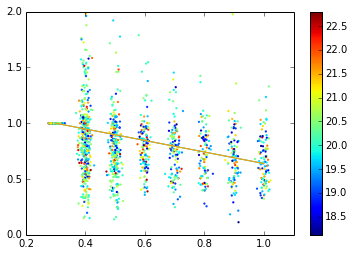

In [10]:
fit_and_plot(x, yn, mu, fzeta_lin_mu_none, 2)

----------------------

## $\frac{f}{f_{0}}=1 - {\zeta} * (z-z_{0})$

$\zeta = \zeta[0]+\zeta[1] * \mu$



AIC for this model = 750.004599105


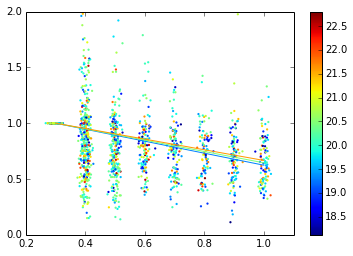

In [11]:
fit_and_plot(x, yn, mu, fzeta_lin_mu_lin, 3)


## $\frac{f}{f_{0}}=e^{\frac{-(z-z_0)}{\zeta}}$

$\zeta = constant$

AIC for this model = 745.528686818


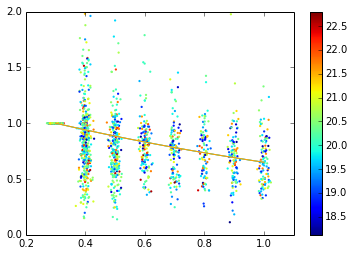

In [12]:
fit_and_plot(x, yn, mu, fzeta_exp_mu_none, 2)

----------------------

## $\frac{f}{f_{0}}=e^{\frac{-(z-z_0)}{\zeta}}$

$\zeta = \zeta[0]+\zeta[1] * \mu$


AIC for this model = 747.171442903


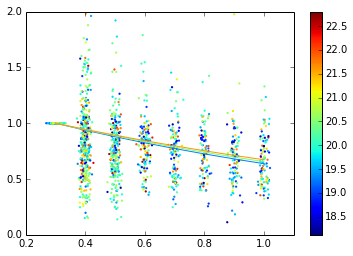

In [13]:
p = fit_and_plot(x, yn, mu, fzeta_exp_mu_lin, 3)

----------------------


## $\frac{f}{f_{0}}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2$

$\zeta_{a}, \zeta_{b} = constant$



AIC for this model = 743.602804337


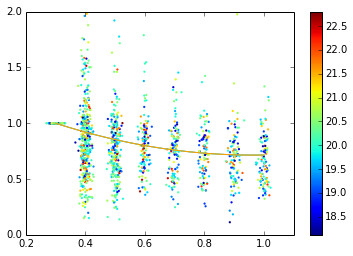

In [15]:
fit_and_plot(x, yn, mu, fzeta_qud_mu_none, 3)

----------------------


## $\frac{f}{f_{0}}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2$

$\zeta_{a} = \zeta_{a}[0] + \zeta_{a}[1] * \mu $

$\zeta_{b} = \zeta_{b}[0] + \zeta_{b}[1] * \mu $


AIC for this model = 747.015705532


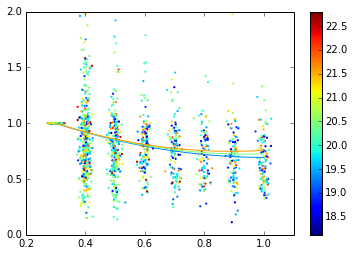

In [18]:
fit_and_plot(x, yn, mu, fzeta_qud_mu_lin, 5)

----------------------
## $\frac{f}{f_{0}}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2 + \zeta_{c}*(z-z_{0})^3$

$\zeta_{a}, \zeta_{b}, \zeta_{c} = constant$




AIC for this model = 746.493301714


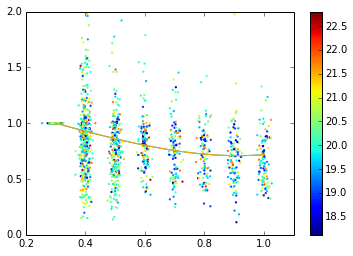

In [16]:
fit_and_plot(x, yn, mu, fzeta_cub_mu_none, 4)

---------------------------------------------------------------------------------------------
## $\frac{f}{f_{0}}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2 + \zeta_{c}*(z-z_{0})^3$

$\zeta_{a} = \zeta_{a}[0] + \zeta_{a}[1] * \mu $

$\zeta_{b} = \zeta_{b}[0] + \zeta_{b}[1] * \mu $

$\zeta_{c} = \zeta_{c}[0] + \zeta_{c}[1] * \mu $



AIC for this model = 750.040876915


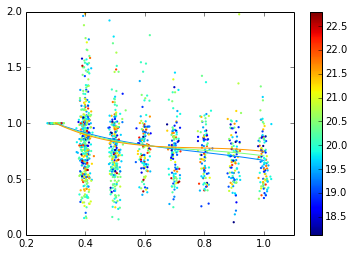

In [17]:
fit_and_plot(x, yn, mu, fzeta_cub_mu_lin, 7)

## Using alternative normalisation, as in eqn. 4: (f(z0)-1) / (f(z)-1)

----------------------

## $\frac{1-f_{0}}{1-f}=1 - {\zeta} * (z-z_{0})$

$\zeta = constant$



AIC for this model = -71.0728625198


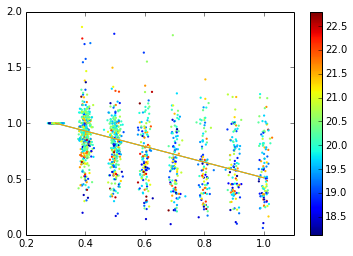

In [22]:
fit_and_plot(x, ym, mu, fzeta_lin_mu_none, 2)

----------------------

## $\frac{1-f_{0}}{1-f}=1 - {\zeta} * (z-z_{0})$

$\zeta = \zeta[0]+\zeta[1] * \mu$



AIC for this model = -70.1590795572


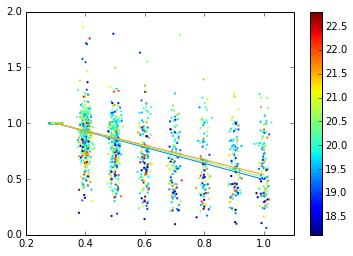

In [7]:
fit_and_plot(x, ym, mu, fzeta_lin_mu_lin, 3)

----------------------------------
## $\frac{1-f_{0}}{1-f}=e^{\frac{-(z-z_0)}{\zeta}}$

$\zeta = constant$

AIC for this model = -88.6501467096


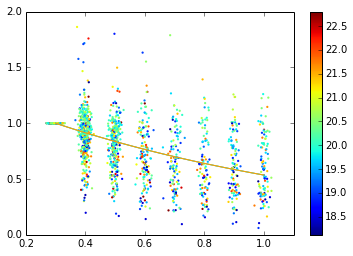

In [8]:
fit_and_plot(x, ym, mu, fzeta_exp_mu_none, 2)

---------------------------------------------
## $\frac{1-f_{0}}{1-f}=e^{\frac{-(z-z_0)}{\zeta}}$

$\zeta = \zeta[0]+\zeta[1] * \mu$


AIC for this model = -89.0754205842


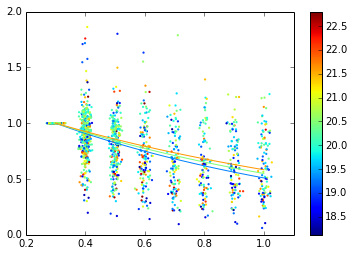

In [9]:
fit_and_plot(x, ym, mu, fzeta_exp_mu_lin, 3)

----------------------


##  $\frac{1-f_{0}}{1-f}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2$

$\zeta_{a}, \zeta_{b} = constant$



AIC for this model = -99.5780253403


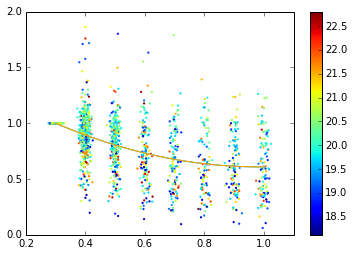

In [10]:
fit_and_plot(x, ym, mu, fzeta_qud_mu_none, 3)

----------------------


##  $\frac{1-f_{0}}{1-f}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2$

$\zeta_{a} = \zeta_{a}[0] + \zeta_{a}[1] * \mu $

$\zeta_{b} = \zeta_{b}[0] + \zeta_{b}[1] * \mu $



AIC for this model = -97.3091950931


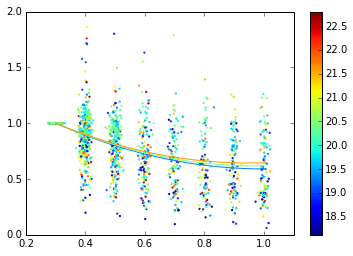

In [11]:
fit_and_plot(x, ym, mu, fzeta_qud_mu_lin, 5)

----------------------
## $\frac{1-f_{0}}{1-f}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2 + \zeta_{c}*(z-z_{0})^3$

$\zeta_{a}, \zeta_{b}, \zeta_{c} = constant$




AIC for this model = -98.5820776738


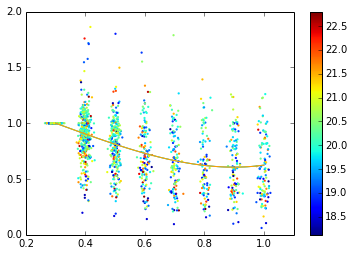

In [12]:
fit_and_plot(x, ym, mu, fzeta_cub_mu_none, 4)

---------------------------------------------------------------------------------------------
## $\frac{1-f_{0}}{1-f}= 1 - \zeta_{a}*(z-z_{0}) + \zeta_{b}*(z-z_{0})^2 + \zeta_{c}*(z-z_{0})^3$

$\zeta_{a} = \zeta_{a}[0] + \zeta_{a}[1] * \mu $

$\zeta_{b} = \zeta_{b}[0] + \zeta_{b}[1] * \mu $

$\zeta_{c} = \zeta_{c}[0] + \zeta_{c}[1] * \mu $



AIC for this model = -94.2640510119


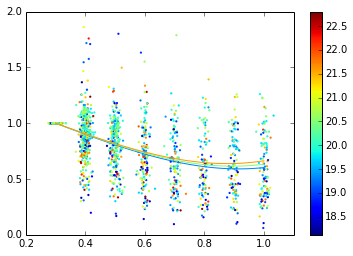

In [13]:
fit_and_plot(x, ym, mu, fzeta_cub_mu_lin, 7)

## We have tested several models for fitting the FERENGI data. 

## The difference in AIC between the exponential model and the quadratic, which had the lowest AIC, was $\Delta$ AIC < 10 between -89.1 (exponential) and -99.5 (quadratic). This difference would indicate based in Burnham & Anderson 2002 that the exponential has less support than the quadratic to be the preferred fit, but is not ruled out since the difference does not exceed 10. However we refrain from choosing this because it does not meet the boundary conditions required by the debiasing equation, which should be bounded between 0 and 1. 

## Between the exponential fit with a constant $\zeta$ and the exponential fit with the linear $\zeta$, the difference in AIC was $\Delta$ AIC < 1. This within the threshold of $\Delta$ AIC < 2, indicating both models have substantial support. As both models are of equal quality based on this test, we choose to keep the more general, linear form. 